In [1]:
import os
import random
import numpy as np
import rasterio
import matplotlib.pyplot as plt 
import pandas as pd
import statistics
import seaborn as sn
import json
import geopandas as gpd
import spacv

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report

from tensorflow.python.client import device_lib
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.applications.densenet import DenseNet201 as DenseNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from focal_loss import BinaryFocalLoss
from keras import backend as K 
from shapely import wkt

from IAdeforestation.preprocessing import *
from IAdeforestation.training import *
from IAdeforestation.tools import *
from IAdeforestation.spatial_cross_val import * 

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
print(device_lib.list_local_devices())

K.clear_session()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2222513327927158526
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7783953216
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10226387056602848746
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
SAVED_MODELS_PATH = os.path.join('saved_models', 'transfer_learning')
SAVED_DATASET_PATH = "datasets"
vietnam = gpd.read_file(os.path.join("district","diaphanhuyen.shp"))
#IMAGES_DIR = 'D:\\fall_images' # For 64x64 images
#IMAGES_DIR = 'images'
#IMAGES_DIR = 'D:\img32' # For 32x32 images

## Load base model

In [4]:
source_model = load_model("transfer_learning_model/dense_ms_from_scratch.209-0.990.hdf5", compile=False)
source_model.trainable = False

In [5]:
#source_model = change_model(source_model, new_input_shape=(None, 32,32,13),custom_objects={'LeakyReLU':LeakyReLU})

In [6]:
source_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 13)] 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 70, 70, 13)   0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   40768       zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [7]:
def create_model():
    # Add new layer to pre-trained network
    flat1 = Flatten()(source_model.layers[-3].output)
    dropout_flatten = Dropout(0.5)(flat1)

    dense256 = Dense(128, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001))(dropout_flatten)
    dropout256 = Dropout(0.5)(dense256)

    dense32 = Dense(32, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001))(dropout256)
    dropout32 = Dropout(0.5)(dense32)

    output = Dense(1, activation='sigmoid')(dropout32)

    return Model(inputs=source_model.input, outputs=output)

# Coffee vs other
## Model creation

In [23]:
model = create_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 13)] 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 38, 38, 13)   0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   40768       zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

## Load Data

In [15]:
PATH_COFFEE = os.path.join(IMAGES_DIR, '2')
path1 = [os.path.join(PATH_COFFEE, s) for s in os.listdir(PATH_COFFEE)]
np.random.shuffle(path1)
class1 = [0]*len(path1)

In [16]:
other_class_dir = list(range(1,32))
other_class_dir.remove(2)
path2 = []

for p in other_class_dir:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(p))):
        path2.append(os.path.join(IMAGES_DIR, str(p), name))
        
path2 = random.sample(path2, len(path1)) # Take the same number of img as class 0
random.shuffle(path2)
class2 = [1]*len(path2)

In [17]:
file_paths = np.asarray(path1 + path2)
classes = np.asarray(class1 + class2)
path_train, path_test, y_train, y_test = train_test_split(file_paths, classes, test_size=0.20)

In [101]:
# Params
BATCH_SIZE = 64
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 3
EPOCH = 100
RUN_NAME = 'test'
LOGS_PATH = 'logs'

In [102]:
train_generator = generator(path_train, 
                            y_train, 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=BATCH_SIZE, 
                            is_data_augmentation=True)

test_generator = generator(path_test, 
                           y_test, 
                           eurosat_params['mean'], 
                           eurosat_params['std'], 
                           batch_size=BATCH_SIZE, 
                           is_data_augmentation=False)

In [103]:
earlystopper = EarlyStopping(monitor='accuracy',patience=30,restore_best_weights=True)
#tensorboard = TensorBoard(log_dir=os.path.join('logs', RUN_NAME),histogram_freq=1)

In [ ]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(train_generator,
                        epochs=EPOCH,
                        steps_per_epoch=int(len(path_train)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=test_generator,
                        validation_steps=int(len(path_test)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        callbacks=[earlystopper])

Epoch 1/100
 77/147 [==============>...............] - ETA: 9s - loss: 2.4839 - accuracy: 0.6449

In [28]:
os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME))

model.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '.h5'))

np.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '.npy'),history.history)

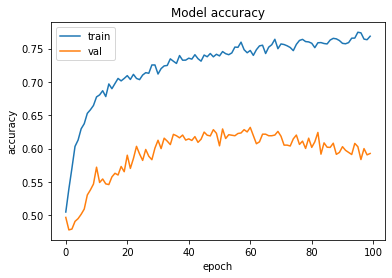

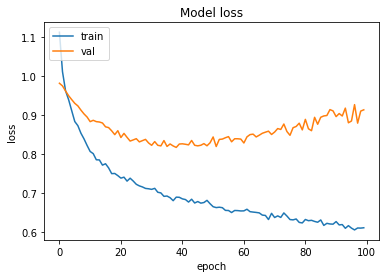

In [29]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model evaluation

In [17]:
test_generator = generator(path_test, y_test, eurosat_params['mean'], eurosat_params['std'], batch_size=BATCH_SIZE)
model.evaluate_generator(test_generator,30)

[0.6172418137391408, 0.7651042]

In [32]:
Y_true = []
Y_pred = []
for i in range (0,30):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(final_model.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)

In [33]:
cm = confusion_matrix(Y_true, Y_pred)

In [34]:
cm

array([[944,  43],
       [473, 460]], dtype=int64)

In [35]:
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

              precision    recall  f1-score   support

           0       0.67      0.96      0.79       987
           1       0.91      0.49      0.64       933

    accuracy                           0.73      1920
   macro avg       0.79      0.72      0.71      1920
weighted avg       0.79      0.73      0.72      1920

F1-Score : 0.6406685236768802


## Spatial Cross val

In [29]:
all_data = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'spring_all.csv')))
all_data['geometry'] = all_data['geometry'].apply(wkt.loads)
all_data.loc[all_data['label'] != 2, 'label'] = 1
all_data.loc[all_data['label'] == 2, 'label'] = 0

coffee_data = all_data[all_data['label'] == 0].reset_index(drop=True)
other_data = all_data[all_data['label']  == 1].reset_index(drop=True)

In [30]:
nb_0 = len(all_data[all_data['label']==0])
nb_1 = len(all_data[all_data['label']==1])
total = nb_0 + nb_1

weight_for_0 = (1 / nb_0)*(total)/2.0 
weight_for_1 = (1 / nb_1)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [31]:
nb_labels = all_data['label'].value_counts().to_dict()
prop0 = nb_labels[0]/(nb_labels[0]+nb_labels[1])
prop1 = nb_labels[1]/(nb_labels[0]+nb_labels[1])

print(prop0)
print(prop1)

0.24163027656477437
0.7583697234352256


In [32]:
vietnam = gpd.read_file(os.path.join("district","diaphanhuyen.shp"))

In [33]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 3
RUN_NAME = 'class_spacv_coffee_3'
NB_FOLD = 5

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME))
    
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall')
]

In [34]:
def display_cross_val_map_class(data_train, data_val, maps, title, xlim=[106,110], ylim=[10,16], figsize=(12,6)):
    fig, axes = plt.subplots(1,2,figsize=figsize)

    maps.plot(ax=axes[0],facecolor='Grey', edgecolor='k',alpha=0.5,linewidth=0.3)
    maps.plot(ax=axes[1],facecolor='Grey', edgecolor='k',alpha=0.5,linewidth=0.3)

    data_train[data_train['label'] == 0].plot(ax=axes[0], markersize=1,categorical=True, legend=True, c="tab:green")
    data_val[data_val['label'] == 0].plot(ax=axes[0], markersize=1,categorical=True, legend=True, c="tab:orange")
    
    data_train[data_train['label'] == 1].plot(ax=axes[1], markersize=1,categorical=True, legend=True, c="tab:pink")
    data_val[data_val['label'] == 1].plot(ax=axes[1], markersize=1,categorical=True, legend=True, c="tab:blue")

    axes[0].set_xlim(xlim)
    axes[0].set_ylim(ylim)

    axes[0].set_xlabel("Latitude")
    axes[0].set_ylabel("Longitude")
    
    axes[1].set_xlim(xlim)
    axes[1].set_ylim(ylim)

    axes[1].set_xlabel("Latitude")
    axes[1].set_ylabel("Longitude")

    legend = axes[0].legend(["Train coffee", "Val coffee"])
    legend.legendHandles[0]._sizes = [30]
    legend.legendHandles[1]._sizes = [30]
    
    legend = axes[1].legend(["Train other", "Val other"])
    legend.legendHandles[0]._sizes = [30]
    legend.legendHandles[1]._sizes = [30]

    fig.suptitle(title)

In [35]:
def compute_score(val_gen, model):
    
    test_generator = generator(val_gen['path'].to_numpy(), 
                        val_gen['label'].to_numpy(), 
                        eurosat_params['mean'], 
                        eurosat_params['std'], 
                        batch_size=len(val_gen))
    
    model.evaluate(test_generator,steps=1)
    Y_true = []
    Y_pred = []
    for i in range (0,1):
        X, Y = next(test_generator)
        Y_pred.extend(np.where(model.predict(X) > 0.5, 1, 0))

        Y_true.extend(Y.tolist())

    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)
    cm = confusion_matrix(Y_true, Y_pred)
    print(cm)
    
    print(classification_report(Y_true, Y_pred))
    print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

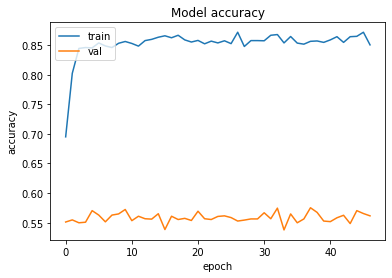

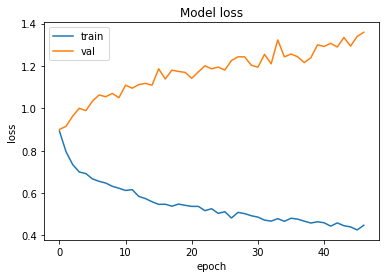

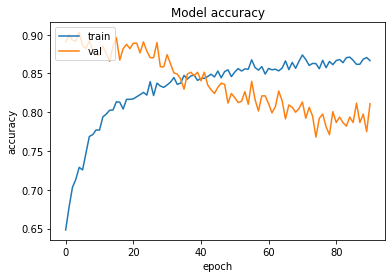

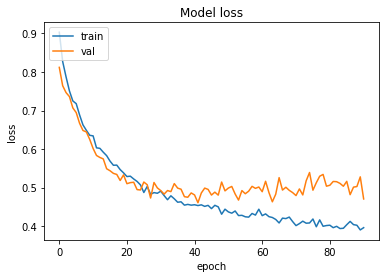

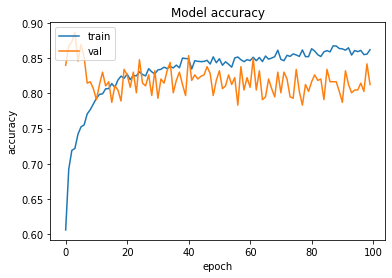

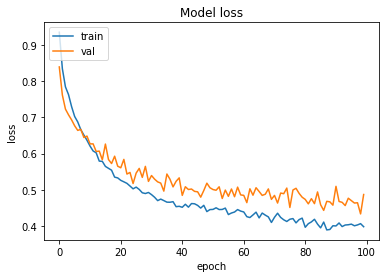

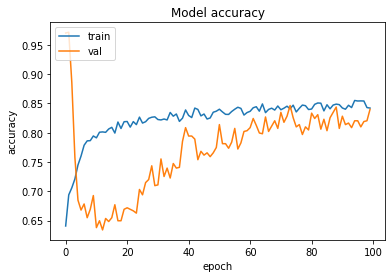

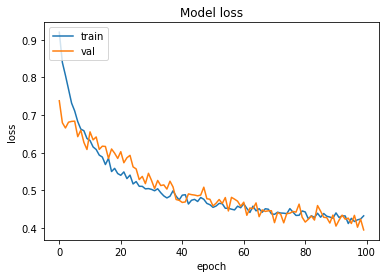

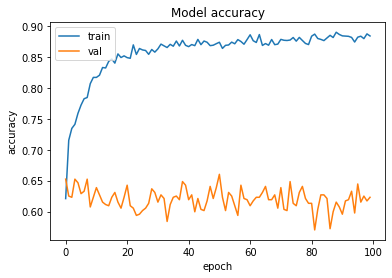

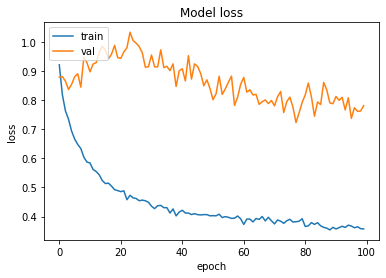

In [28]:
i = 0
for i in range(0,5):
    a = np.load('saved_models/transfer_learning/Coffee/spacv_coffee_1/spacv_coffee_1_' + str(i) +'.npy', allow_pickle=True).item()
    # summarize history for accuracy
    plt.plot(a['accuracy'])
    plt.plot(a['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(a['loss'])
    plt.plot(a['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
skcv_coffee = spacv.SKCV(n_splits=5, buffer_radius=0.1).split(coffee_data['geometry'])
skcv_other = spacv.SKCV(n_splits=5, buffer_radius=0.1).split(other_data['geometry'])

fold_index = 0

results = []

for coffee, other in zip(skcv_coffee, skcv_other):

    geo_train = coffee_data.iloc[coffee[0]].append(other_data.iloc[other[0]], ignore_index=True)
    geo_val = coffee_data.iloc[coffee[1]].append(other_data.iloc[other[1]], ignore_index=True)
    
    print(f"Fold {fold_index+1} Number coffee - train : {len(geo_train[geo_train['label'] == 0])}")
    print(f"Fold {fold_index+1} Number no-coffee - train : {len(geo_train[geo_train['label'] == 1])}")

    print(f"Fold {fold_index+1} Number coffee - val : {len(geo_val[geo_val['label'] == 0])}")
    print(f"Fold {fold_index+1} Number no-coffee - val : {len(geo_val[geo_val['label'] == 1])}")
    print("-----")

    display_cross_val_map_class(geo_train, geo_val, vietnam, f"Cross validation split fold : {fold_index}")
    
    print(f"Training for fold {fold_index}")

    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE, 
                                is_data_augmentation=True)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                        epochs=EPOCH,
                        steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=validation_generator,
                        validation_steps=(len(geo_val)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        callbacks=[earlystopper],
                        class_weight=class_weight)

    model.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    result.append(2*((result[2]*result[3])/(result[2]+result[3])))
    results.append(result)
    
    print(f"Fold {fold_index} loss : {result[0]}")
    print(f"Fold {fold_index} accuracy : {result[1]}")
    print(f"Fold {fold_index} F1-score : {result[4]}")
    
    compute_score(geo_val, model)

    print("\n")

    K.clear_session()

    fold_index+=1

Fold 1 Number coffee - train : 204
Fold 1 Number no-coffee - train : 1089
Fold 1 Number coffee - val : 214
Fold 1 Number no-coffee - val : 459
-----
Training for fold 0
Epoch 1/100
60/60 [==============================] - 19s 210ms/step - loss: 0.9256 - accuracy: 0.5945 - precision: 0.8364 - recall: 0.6406 - val_loss: 0.8781 - val_accuracy: 0.6979 - val_precision: 0.6918 - val_recall: 0.9969
Epoch 2/100
60/60 [==============================] - 10s 175ms/step - loss: 0.8728 - accuracy: 0.6774 - precision: 0.8481 - recall: 0.7494 - val_loss: 0.8192 - val_accuracy: 0.7031 - val_precision: 0.7005 - val_recall: 0.9970
Epoch 3/100
60/60 [==============================] - 10s 176ms/step - loss: 0.8499 - accuracy: 0.7386 - precision: 0.8605 - recall: 0.8236 - val_loss: 0.7851 - val_accuracy: 0.6901 - val_precision: 0.6852 - val_recall: 0.9985
Epoch 4/100
60/60 [==============================] - 11s 178ms/step - loss: 0.8255 - accuracy: 0.7492 - precision: 0.8604 - recall: 0.8396 - val_loss: 0.

60/60 [==============================] - 10s 173ms/step - loss: 0.5676 - accuracy: 0.8050 - precision: 0.9290 - recall: 0.8330 - val_loss: 0.5719 - val_accuracy: 0.7500 - val_precision: 0.7678 - val_recall: 0.8981
Epoch 37/100
60/60 [==============================] - 10s 174ms/step - loss: 0.5316 - accuracy: 0.8261 - precision: 0.9357 - recall: 0.8545 - val_loss: 0.5650 - val_accuracy: 0.7609 - val_precision: 0.7710 - val_recall: 0.9218
Epoch 38/100
60/60 [==============================] - 10s 173ms/step - loss: 0.5352 - accuracy: 0.8275 - precision: 0.9322 - recall: 0.8591 - val_loss: 0.5262 - val_accuracy: 0.7729 - val_precision: 0.7855 - val_recall: 0.9212
Epoch 39/100
60/60 [==============================] - 10s 174ms/step - loss: 0.5466 - accuracy: 0.8202 - precision: 0.9430 - recall: 0.8385 - val_loss: 0.5380 - val_accuracy: 0.7698 - val_precision: 0.7734 - val_recall: 0.9357
Epoch 40/100
60/60 [==============================] - 10s 174ms/step - loss: 0.5643 - accuracy: 0.8012 - 

60/60 [==============================] - 10s 174ms/step - loss: 0.4952 - accuracy: 0.8296 - precision: 0.9435 - recall: 0.8462 - val_loss: 0.5359 - val_accuracy: 0.7734 - val_precision: 0.7920 - val_recall: 0.9062
Epoch 73/100
60/60 [==============================] - 10s 174ms/step - loss: 0.4783 - accuracy: 0.8368 - precision: 0.9467 - recall: 0.8543 - val_loss: 0.5287 - val_accuracy: 0.7807 - val_precision: 0.7958 - val_recall: 0.9062
Epoch 74/100
60/60 [==============================] - 10s 172ms/step - loss: 0.4960 - accuracy: 0.8169 - precision: 0.9417 - recall: 0.8356 - val_loss: 0.5324 - val_accuracy: 0.7880 - val_precision: 0.8035 - val_recall: 0.9131
Epoch 75/100
60/60 [==============================] - 10s 174ms/step - loss: 0.4709 - accuracy: 0.8291 - precision: 0.9512 - recall: 0.8415 - val_loss: 0.5266 - val_accuracy: 0.7833 - val_precision: 0.8042 - val_recall: 0.9024
Epoch 76/100
60/60 [==============================] - 10s 172ms/step - loss: 0.4796 - accuracy: 0.8293 - 

72/72 [==============================] - 11s 151ms/step - loss: 0.8420 - accuracy: 0.6783 - precision: 0.8841 - recall: 0.6701 - val_loss: 0.8847 - val_accuracy: 0.6793 - val_precision: 0.7807 - val_recall: 0.8215
Epoch 5/100
72/72 [==============================] - 11s 149ms/step - loss: 0.8276 - accuracy: 0.6915 - precision: 0.8821 - recall: 0.6811 - val_loss: 0.8664 - val_accuracy: 0.6935 - val_precision: 0.7938 - val_recall: 0.8167
Epoch 6/100
72/72 [==============================] - 11s 149ms/step - loss: 0.7958 - accuracy: 0.7319 - precision: 0.8993 - recall: 0.7209 - val_loss: 0.8457 - val_accuracy: 0.6756 - val_precision: 0.7866 - val_recall: 0.8030
Epoch 7/100
72/72 [==============================] - 11s 148ms/step - loss: 0.7842 - accuracy: 0.6961 - precision: 0.9141 - recall: 0.6574 - val_loss: 0.8308 - val_accuracy: 0.6756 - val_precision: 0.7750 - val_recall: 0.8196
Epoch 8/100
72/72 [==============================] - 11s 148ms/step - loss: 0.7619 - accuracy: 0.7090 - prec

72/72 [==============================] - 11s 149ms/step - loss: 0.4728 - accuracy: 0.8349 - precision: 0.9619 - recall: 0.8079 - val_loss: 0.7737 - val_accuracy: 0.7292 - val_precision: 0.7726 - val_recall: 0.9234
Epoch 41/100
72/72 [==============================] - 10s 147ms/step - loss: 0.4854 - accuracy: 0.8228 - precision: 0.9502 - recall: 0.8041 - val_loss: 0.7958 - val_accuracy: 0.7210 - val_precision: 0.7627 - val_recall: 0.9256
Epoch 42/100
72/72 [==============================] - 11s 148ms/step - loss: 0.4942 - accuracy: 0.8150 - precision: 0.9506 - recall: 0.7937 - val_loss: 0.7897 - val_accuracy: 0.7225 - val_precision: 0.7682 - val_recall: 0.9194
Epoch 43/100
72/72 [==============================] - 11s 148ms/step - loss: 0.4743 - accuracy: 0.8283 - precision: 0.9639 - recall: 0.7975 - val_loss: 0.7528 - val_accuracy: 0.7507 - val_precision: 0.7881 - val_recall: 0.9370
Epoch 44/100
72/72 [==============================] - 11s 148ms/step - loss: 0.4582 - accuracy: 0.8353 - 

72/72 [==============================] - 10s 146ms/step - loss: 0.4332 - accuracy: 0.8496 - precision: 0.9624 - recall: 0.8327 - val_loss: 0.8701 - val_accuracy: 0.7344 - val_precision: 0.7651 - val_recall: 0.9438
Epoch 77/100
72/72 [==============================] - 11s 149ms/step - loss: 0.4587 - accuracy: 0.8367 - precision: 0.9539 - recall: 0.8210 - val_loss: 0.8710 - val_accuracy: 0.7292 - val_precision: 0.7658 - val_recall: 0.9344
Epoch 78/100
72/72 [==============================] - 10s 147ms/step - loss: 0.4000 - accuracy: 0.8632 - precision: 0.9696 - recall: 0.8457 - val_loss: 0.8674 - val_accuracy: 0.7284 - val_precision: 0.7693 - val_recall: 0.9280
Epoch 79/100
72/72 [==============================] - 11s 148ms/step - loss: 0.4117 - accuracy: 0.8526 - precision: 0.9703 - recall: 0.8313 - val_loss: 0.8563 - val_accuracy: 0.7388 - val_precision: 0.7709 - val_recall: 0.9444
Epoch 80/100
72/72 [==============================] - 11s 148ms/step - loss: 0.4237 - accuracy: 0.8487 - 

69/69 [==============================] - 11s 154ms/step - loss: 0.7399 - accuracy: 0.7458 - precision: 0.8872 - recall: 0.7815 - val_loss: 0.8143 - val_accuracy: 0.6693 - val_precision: 0.9008 - val_recall: 0.6076
Epoch 9/100
69/69 [==============================] - 11s 154ms/step - loss: 0.7097 - accuracy: 0.7422 - precision: 0.9043 - recall: 0.7610 - val_loss: 0.8090 - val_accuracy: 0.6777 - val_precision: 0.8941 - val_recall: 0.6159
Epoch 10/100
69/69 [==============================] - 11s 154ms/step - loss: 0.6990 - accuracy: 0.7696 - precision: 0.9100 - recall: 0.7861 - val_loss: 0.7905 - val_accuracy: 0.6979 - val_precision: 0.9334 - val_recall: 0.6287
Epoch 11/100
69/69 [==============================] - 11s 154ms/step - loss: 0.6806 - accuracy: 0.7530 - precision: 0.9040 - recall: 0.7762 - val_loss: 0.7665 - val_accuracy: 0.7207 - val_precision: 0.8996 - val_recall: 0.6657
Epoch 12/100
69/69 [==============================] - 11s 155ms/step - loss: 0.6724 - accuracy: 0.7566 - p

69/69 [==============================] - 11s 156ms/step - loss: 0.4758 - accuracy: 0.8286 - precision: 0.9556 - recall: 0.8310 - val_loss: 0.5799 - val_accuracy: 0.8001 - val_precision: 0.8814 - val_recall: 0.8399
Epoch 45/100
69/69 [==============================] - 11s 154ms/step - loss: 0.5050 - accuracy: 0.8219 - precision: 0.9485 - recall: 0.8220 - val_loss: 0.5870 - val_accuracy: 0.7832 - val_precision: 0.8539 - val_recall: 0.8422
Epoch 46/100
69/69 [==============================] - 10s 154ms/step - loss: 0.4956 - accuracy: 0.8276 - precision: 0.9526 - recall: 0.8272 - val_loss: 0.5740 - val_accuracy: 0.7858 - val_precision: 0.8646 - val_recall: 0.8342
Epoch 47/100
69/69 [==============================] - 11s 154ms/step - loss: 0.4963 - accuracy: 0.8180 - precision: 0.9488 - recall: 0.8184 - val_loss: 0.5748 - val_accuracy: 0.7917 - val_precision: 0.8638 - val_recall: 0.8315
Epoch 48/100
69/69 [==============================] - 10s 153ms/step - loss: 0.4875 - accuracy: 0.8213 - 

69/69 [==============================] - 10s 153ms/step - loss: 0.4580 - accuracy: 0.8288 - precision: 0.9555 - recall: 0.8224 - val_loss: 0.5534 - val_accuracy: 0.7982 - val_precision: 0.8612 - val_recall: 0.8565
Epoch 81/100
69/69 [==============================] - 11s 155ms/step - loss: 0.4582 - accuracy: 0.8354 - precision: 0.9602 - recall: 0.8279 - val_loss: 0.5308 - val_accuracy: 0.8203 - val_precision: 0.8730 - val_recall: 0.8808
Epoch 82/100
69/69 [==============================] - 10s 154ms/step - loss: 0.4530 - accuracy: 0.8429 - precision: 0.9626 - recall: 0.8373 - val_loss: 0.5323 - val_accuracy: 0.8132 - val_precision: 0.8732 - val_recall: 0.8709
Epoch 83/100
69/69 [==============================] - 10s 153ms/step - loss: 0.4637 - accuracy: 0.8303 - precision: 0.9533 - recall: 0.8325 - val_loss: 0.5413 - val_accuracy: 0.8086 - val_precision: 0.8660 - val_recall: 0.8722
Epoch 84/100
69/69 [==============================] - 10s 154ms/step - loss: 0.4647 - accuracy: 0.8275 - 

81/81 [==============================] - 10s 129ms/step - loss: 0.6795 - accuracy: 0.7559 - precision: 0.9327 - recall: 0.7124 - val_loss: 0.9358 - val_accuracy: 0.5117 - val_precision: 0.9972 - val_recall: 0.4898
Epoch 15/100
81/81 [==============================] - 11s 131ms/step - loss: 0.6700 - accuracy: 0.7582 - precision: 0.9303 - recall: 0.7186 - val_loss: 0.9297 - val_accuracy: 0.5169 - val_precision: 0.9916 - val_recall: 0.4917
Epoch 16/100
81/81 [==============================] - 10s 129ms/step - loss: 0.6391 - accuracy: 0.7710 - precision: 0.9391 - recall: 0.7321 - val_loss: 0.9011 - val_accuracy: 0.5404 - val_precision: 0.9868 - val_recall: 0.5187
Epoch 17/100
81/81 [==============================] - 10s 130ms/step - loss: 0.6319 - accuracy: 0.7718 - precision: 0.9314 - recall: 0.7376 - val_loss: 0.8845 - val_accuracy: 0.5469 - val_precision: 0.9894 - val_recall: 0.5202
Epoch 18/100
81/81 [==============================] - 10s 130ms/step - loss: 0.6394 - accuracy: 0.7763 - 

In [14]:
with open(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

In [15]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.71171875
Stdev accuracy : 0.08864347700550221


Mean loss : 0.6661522090435028
Stdev loss : 0.19842668503298444


Mean precision : 0.85694899559021
Stdev precision : 0.06181590413348208


Mean recall : 0.7258374810218811
Stdev recall : 0.20134318086907702


Mean F1-Score : 0.764749304315897
Stdev F1-Score : 0.11211601554184514


In [16]:
restored_model = load_model(os.path.join("saved_models/transfer_learning/Coffee/strat_spacv_coffee_32_1/strat_spacv_coffee_32_1_1.h5"), custom_objects={'LeakyReLU':LeakyReLU})
#restored_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

In [17]:
data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'spring_test_32.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

data_test.loc[data_test['label'] != 2, 'label'] = 1
data_test.loc[data_test['label'] == 2, 'label'] = 0

1/1 [==============================] - 6s 6s/step - loss: 0.6726 - accuracy: 0.7042 - precision: 0.7732 - recall: 0.8785
              precision    recall  f1-score   support

           0       0.22      0.12      0.16       211
           1       0.78      0.87      0.82       749

    accuracy                           0.71       960
   macro avg       0.50      0.50      0.49       960
weighted avg       0.66      0.71      0.68       960

F1-Score : 0.8244178728760226


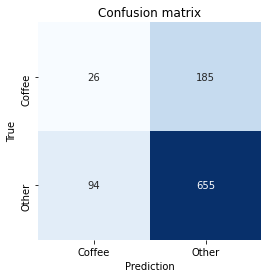

In [18]:
test_generator = generator(data_test['path'].to_numpy(), 
                            data_test['label'].to_numpy(), 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=len(data_test))
restored_model.evaluate(test_generator,steps=1)
Y_true = []
Y_pred = []
for i in range (0,1):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(restored_model.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)
cm = confusion_matrix(Y_true, Y_pred)
plot_confusion_matrix(cm, ["Coffee", "Other"])
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

### Stratified cross-val

In [8]:
data_train = gpd.GeoDataFrame(pd.read_csv(os.path.join( 'datasets', 'new_strat_spring_train.csv')))
data_train['geometry'] = data_train['geometry'].apply(wkt.loads)

In [9]:
nb_0 = len(data_train[data_train['label']==0])
nb_1 = len(data_train[data_train['label']==1])
total = nb_0 + nb_1

weight_for_0 = (1 / nb_0)*(total)/2.0 
weight_for_1 = (1 / nb_1)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [10]:
# Params
BATCH_SIZE = 256
EPOCH = 300
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 3
RUN_NAME = 'start_coffee_300E_focal_2'
NB_FOLD = 5

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME))
    
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall')
]

In [11]:

fold_index = 0

results = []

skf = StratifiedKFold(n_splits=5)
for train, validation in skf.split(data_train['path'].to_numpy(), data_train['label'].to_numpy()):
    
    geo_train = data_train.iloc[train]
    geo_val = data_train.iloc[validation]
    
    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE, 
                                is_data_augmentation=True)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(loss=BinaryFocalLoss(gamma=2), optimizer=Adam(learning_rate=LEARNING_RATE), metrics=METRICS)

    history = model.fit(train_generator,
                                epochs=EPOCH,
                                steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                validation_data=validation_generator,
                                validation_steps=(len(geo_val)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                callbacks=[earlystopper],
                                class_weight=class_weight)

    model.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    result.append(2*((result[2]*result[3])/(result[2]+result[3])))
    results.append(result)
    
    print(f"Fold {fold_index} loss : {result[0]}")
    print(f"Fold {fold_index} accuracy : {result[1]}")
    print(f"Fold {fold_index} F1-score : {result[4]}")
    print("\n")

    K.clear_session()

    fold_index+=1
    

Epoch 1/300
15/15 [==============================] - 20s 771ms/step - loss: 0.5212 - accuracy: 0.5594 - precision: 0.7806 - recall: 0.5906 - val_loss: 0.4492 - val_accuracy: 0.7201 - val_precision: 0.8429 - val_recall: 0.7782
Epoch 2/300
15/15 [==============================] - 9s 612ms/step - loss: 0.5094 - accuracy: 0.5752 - precision: 0.7648 - recall: 0.6198 - val_loss: 0.4413 - val_accuracy: 0.7266 - val_precision: 0.8602 - val_recall: 0.7662
Epoch 3/300
15/15 [==============================] - 9s 619ms/step - loss: 0.4908 - accuracy: 0.6080 - precision: 0.7894 - recall: 0.6524 - val_loss: 0.4343 - val_accuracy: 0.7279 - val_precision: 0.8661 - val_recall: 0.7573
Epoch 4/300
15/15 [==============================] - 9s 616ms/step - loss: 0.4822 - accuracy: 0.6154 - precision: 0.8024 - recall: 0.6457 - val_loss: 0.4305 - val_accuracy: 0.7240 - val_precision: 0.9022 - val_recall: 0.7131
Epoch 5/300
15/15 [==============================] - 9s 603ms/step - loss: 0.4742 - accuracy: 0.615

15/15 [==============================] - 9s 632ms/step - loss: 0.2894 - accuracy: 0.7883 - precision: 0.9238 - recall: 0.7870 - val_loss: 0.2812 - val_accuracy: 0.7917 - val_precision: 0.9367 - val_recall: 0.7806
Epoch 74/300
15/15 [==============================] - 9s 638ms/step - loss: 0.2803 - accuracy: 0.8007 - precision: 0.9347 - recall: 0.7950 - val_loss: 0.2812 - val_accuracy: 0.7891 - val_precision: 0.9391 - val_recall: 0.7707
Epoch 75/300
15/15 [==============================] - 9s 645ms/step - loss: 0.2890 - accuracy: 0.7856 - precision: 0.9214 - recall: 0.7850 - val_loss: 0.2785 - val_accuracy: 0.8060 - val_precision: 0.9605 - val_recall: 0.7804
Epoch 76/300
15/15 [==============================] - 9s 642ms/step - loss: 0.2821 - accuracy: 0.7943 - precision: 0.9376 - recall: 0.7815 - val_loss: 0.2794 - val_accuracy: 0.7917 - val_precision: 0.9443 - val_recall: 0.7750
Epoch 77/300
15/15 [==============================] - 9s 620ms/step - loss: 0.2825 - accuracy: 0.7974 - preci

15/15 [==============================] - 9s 639ms/step - loss: 0.2284 - accuracy: 0.8001 - precision: 0.9350 - recall: 0.7915 - val_loss: 0.2215 - val_accuracy: 0.8125 - val_precision: 0.9478 - val_recall: 0.7923
Epoch 146/300
15/15 [==============================] - 9s 630ms/step - loss: 0.2296 - accuracy: 0.8015 - precision: 0.9452 - recall: 0.7866 - val_loss: 0.2205 - val_accuracy: 0.8294 - val_precision: 0.9679 - val_recall: 0.8074
Epoch 147/300
15/15 [==============================] - 9s 635ms/step - loss: 0.2285 - accuracy: 0.8020 - precision: 0.9352 - recall: 0.7922 - val_loss: 0.2211 - val_accuracy: 0.8190 - val_precision: 0.9530 - val_recall: 0.8007
Epoch 148/300
15/15 [==============================] - 9s 637ms/step - loss: 0.2218 - accuracy: 0.8095 - precision: 0.9397 - recall: 0.8066 - val_loss: 0.2220 - val_accuracy: 0.8229 - val_precision: 0.9503 - val_recall: 0.8115
Epoch 149/300
15/15 [==============================] - 9s 641ms/step - loss: 0.2224 - accuracy: 0.8180 - p

15/15 [==============================] - 9s 642ms/step - loss: 0.3640 - accuracy: 0.7305 - precision: 0.8973 - recall: 0.7266 - val_loss: 0.3419 - val_accuracy: 0.8021 - val_precision: 0.9213 - val_recall: 0.8069
Epoch 35/300
15/15 [==============================] - 9s 653ms/step - loss: 0.3578 - accuracy: 0.7332 - precision: 0.9054 - recall: 0.7265 - val_loss: 0.3410 - val_accuracy: 0.8060 - val_precision: 0.9226 - val_recall: 0.8140
Epoch 36/300
15/15 [==============================] - 9s 621ms/step - loss: 0.3534 - accuracy: 0.7508 - precision: 0.9045 - recall: 0.7445 - val_loss: 0.3367 - val_accuracy: 0.8164 - val_precision: 0.9129 - val_recall: 0.8354
Epoch 37/300
15/15 [==============================] - 9s 628ms/step - loss: 0.3521 - accuracy: 0.7461 - precision: 0.9042 - recall: 0.7454 - val_loss: 0.3334 - val_accuracy: 0.8164 - val_precision: 0.9198 - val_recall: 0.8296
Epoch 38/300
15/15 [==============================] - 9s 642ms/step - loss: 0.3535 - accuracy: 0.7415 - preci

15/15 [==============================] - 9s 633ms/step - loss: 0.2526 - accuracy: 0.8038 - precision: 0.9298 - recall: 0.8020 - val_loss: 0.2384 - val_accuracy: 0.8451 - val_precision: 0.9266 - val_recall: 0.8647
Epoch 107/300
15/15 [==============================] - 9s 635ms/step - loss: 0.2523 - accuracy: 0.7867 - precision: 0.9246 - recall: 0.7866 - val_loss: 0.2370 - val_accuracy: 0.8633 - val_precision: 0.9352 - val_recall: 0.8783
Epoch 108/300
15/15 [==============================] - 9s 623ms/step - loss: 0.2532 - accuracy: 0.7903 - precision: 0.9305 - recall: 0.7790 - val_loss: 0.2381 - val_accuracy: 0.8477 - val_precision: 0.9316 - val_recall: 0.8630
Epoch 109/300
15/15 [==============================] - 9s 632ms/step - loss: 0.2558 - accuracy: 0.7921 - precision: 0.9156 - recall: 0.7972 - val_loss: 0.2361 - val_accuracy: 0.8555 - val_precision: 0.9404 - val_recall: 0.8647
Epoch 110/300
15/15 [==============================] - 9s 628ms/step - loss: 0.2491 - accuracy: 0.7934 - p

15/15 [==============================] - 9s 636ms/step - loss: 0.3204 - accuracy: 0.7739 - precision: 0.9254 - recall: 0.7616 - val_loss: 0.3077 - val_accuracy: 0.8008 - val_precision: 0.9270 - val_recall: 0.8020
Epoch 53/300
15/15 [==============================] - 9s 634ms/step - loss: 0.3228 - accuracy: 0.7497 - precision: 0.9185 - recall: 0.7403 - val_loss: 0.3040 - val_accuracy: 0.8047 - val_precision: 0.9249 - val_recall: 0.8069
Epoch 54/300
15/15 [==============================] - 9s 635ms/step - loss: 0.3185 - accuracy: 0.7707 - precision: 0.9240 - recall: 0.7629 - val_loss: 0.3049 - val_accuracy: 0.7995 - val_precision: 0.9249 - val_recall: 0.7958
Epoch 55/300
15/15 [==============================] - 9s 629ms/step - loss: 0.3142 - accuracy: 0.7604 - precision: 0.9215 - recall: 0.7536 - val_loss: 0.3018 - val_accuracy: 0.8125 - val_precision: 0.9294 - val_recall: 0.8144
Epoch 56/300
15/15 [==============================] - 9s 631ms/step - loss: 0.3167 - accuracy: 0.7524 - preci

15/15 [==============================] - 9s 627ms/step - loss: 0.2386 - accuracy: 0.8119 - precision: 0.9371 - recall: 0.8066 - val_loss: 0.2274 - val_accuracy: 0.8320 - val_precision: 0.9528 - val_recall: 0.8220
Epoch 125/300
15/15 [==============================] - 9s 628ms/step - loss: 0.2404 - accuracy: 0.8007 - precision: 0.9326 - recall: 0.7943 - val_loss: 0.2265 - val_accuracy: 0.8385 - val_precision: 0.9508 - val_recall: 0.8299
Epoch 126/300
15/15 [==============================] - 9s 640ms/step - loss: 0.2358 - accuracy: 0.8148 - precision: 0.9334 - recall: 0.8141 - val_loss: 0.2264 - val_accuracy: 0.8255 - val_precision: 0.9492 - val_recall: 0.8182
Epoch 127/300
15/15 [==============================] - 9s 634ms/step - loss: 0.2362 - accuracy: 0.8138 - precision: 0.9446 - recall: 0.8020 - val_loss: 0.2253 - val_accuracy: 0.8229 - val_precision: 0.9365 - val_recall: 0.8194
Epoch 128/300
15/15 [==============================] - 9s 624ms/step - loss: 0.2341 - accuracy: 0.8096 - p

15/15 [==============================] - 9s 635ms/step - loss: 0.3189 - accuracy: 0.7660 - precision: 0.9276 - recall: 0.7487 - val_loss: 0.3023 - val_accuracy: 0.8021 - val_precision: 0.9296 - val_recall: 0.7979
Epoch 52/300
15/15 [==============================] - 9s 642ms/step - loss: 0.3199 - accuracy: 0.7610 - precision: 0.9228 - recall: 0.7431 - val_loss: 0.2976 - val_accuracy: 0.8034 - val_precision: 0.9323 - val_recall: 0.8000
Epoch 53/300
15/15 [==============================] - 9s 622ms/step - loss: 0.3237 - accuracy: 0.7581 - precision: 0.9073 - recall: 0.7498 - val_loss: 0.2992 - val_accuracy: 0.8034 - val_precision: 0.9359 - val_recall: 0.7969
Epoch 54/300
15/15 [==============================] - 9s 632ms/step - loss: 0.3109 - accuracy: 0.7645 - precision: 0.9278 - recall: 0.7499 - val_loss: 0.2979 - val_accuracy: 0.7969 - val_precision: 0.9393 - val_recall: 0.7864
Epoch 55/300
15/15 [==============================] - 9s 640ms/step - loss: 0.3154 - accuracy: 0.7709 - preci

15/15 [==============================] - 9s 626ms/step - loss: 0.2402 - accuracy: 0.7941 - precision: 0.9309 - recall: 0.7864 - val_loss: 0.2246 - val_accuracy: 0.8242 - val_precision: 0.9449 - val_recall: 0.8177
Epoch 124/300
15/15 [==============================] - 9s 635ms/step - loss: 0.2389 - accuracy: 0.8005 - precision: 0.9318 - recall: 0.7950 - val_loss: 0.2284 - val_accuracy: 0.8073 - val_precision: 0.9375 - val_recall: 0.7990
Epoch 125/300
15/15 [==============================] - 9s 642ms/step - loss: 0.2396 - accuracy: 0.7983 - precision: 0.9359 - recall: 0.7826 - val_loss: 0.2239 - val_accuracy: 0.8242 - val_precision: 0.9483 - val_recall: 0.8140
Epoch 126/300
15/15 [==============================] - 9s 637ms/step - loss: 0.2319 - accuracy: 0.7960 - precision: 0.9398 - recall: 0.7809 - val_loss: 0.2219 - val_accuracy: 0.8229 - val_precision: 0.9429 - val_recall: 0.8174
Epoch 127/300
15/15 [==============================] - 9s 621ms/step - loss: 0.2322 - accuracy: 0.7998 - p

15/15 [==============================] - 9s 636ms/step - loss: 0.3066 - accuracy: 0.7701 - precision: 0.9304 - recall: 0.7591 - val_loss: 0.3024 - val_accuracy: 0.7826 - val_precision: 0.9314 - val_recall: 0.7698
Epoch 58/300
15/15 [==============================] - 9s 621ms/step - loss: 0.3069 - accuracy: 0.7802 - precision: 0.9258 - recall: 0.7732 - val_loss: 0.3012 - val_accuracy: 0.8021 - val_precision: 0.9479 - val_recall: 0.7818
Epoch 59/300
15/15 [==============================] - 9s 624ms/step - loss: 0.3124 - accuracy: 0.7614 - precision: 0.9144 - recall: 0.7529 - val_loss: 0.3000 - val_accuracy: 0.7865 - val_precision: 0.9490 - val_recall: 0.7615
Epoch 60/300
15/15 [==============================] - 9s 630ms/step - loss: 0.3084 - accuracy: 0.7569 - precision: 0.9183 - recall: 0.7521 - val_loss: 0.2963 - val_accuracy: 0.7839 - val_precision: 0.9367 - val_recall: 0.7655
Epoch 61/300
15/15 [==============================] - 9s 644ms/step - loss: 0.3127 - accuracy: 0.7641 - preci

In [12]:
with open(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

In [13]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.8294921875
Stdev accuracy : 0.013956304753867067


Mean loss : 0.23317112922668456
Stdev loss : 0.013105260976424064


Mean precision : 0.948666799068451
Stdev precision : 0.013562609705077819


Mean recall : 0.8226133465766907
Stdev recall : 0.026636318991991086


Mean F1-Score : 0.8807395952379963
Stdev F1-Score : 0.011456522602124326


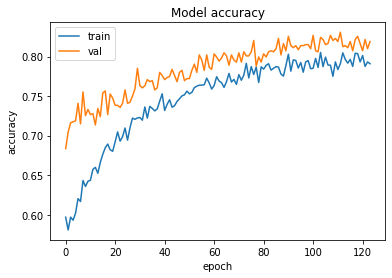

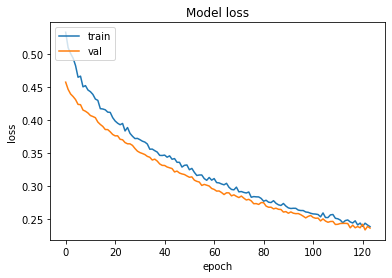

In [14]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
restored_model = load_model(os.path.join("saved_models/transfer_learning/Coffee/start_coffee_300E_focal_2/start_coffee_300E_focal_2_3.h5"), custom_objects={'LeakyReLU':LeakyReLU})

In [22]:
data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join( 'datasets', 'new_strat_spring_test.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

1/1 [==============================] - 3s 3s/step - loss: 0.2277 - accuracy: 0.8257 - precision: 0.9414 - recall: 0.8211
              precision    recall  f1-score   support

           0       0.57      0.82      0.67       100
           1       0.93      0.80      0.86       313

    accuracy                           0.81       413
   macro avg       0.75      0.81      0.77       413
weighted avg       0.85      0.81      0.82       413

F1-Score : 0.8625429553264605


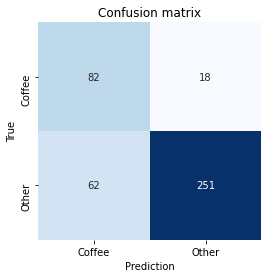

In [23]:
test_generator = generator(data_test['path'].to_numpy(), 
                            data_test['label'].to_numpy(), 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=len(data_test))
restored_model.evaluate(test_generator,steps=1)
Y_true = []
Y_pred = []
for i in range (0,1):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(restored_model.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)
cm = confusion_matrix(Y_true, Y_pred)
plot_confusion_matrix(cm, ["Coffee", "Other"])
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

## Culture vs no culture

In [8]:
culture_list = [1,2,6,15,18,19,17] #  6 caoutchou, 25 poivre de cayenne, 16 cassava, 23 intercrop
no_culture_list = [4,9,10, 24,27] # 11 other tree, 27 pines tree

nb_culture = 0
for c in culture_list:
    nb_culture+= len(os.listdir(os.path.join(IMAGES_DIR, str(c))))

nb_no_culture = 0
for c in no_culture_list:
    nb_no_culture+= len(os.listdir(os.path.join(IMAGES_DIR, str(c))))

In [9]:
path_culture = []

for c in culture_list:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(c))):
        path_culture.append(os.path.join(IMAGES_DIR, str(c), name))
np.random.shuffle(path_culture)
class_culture = [0]*len(path_culture)
        
path_no_culture = []

for c in no_culture_list:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(c))):
        path_no_culture.append(os.path.join(IMAGES_DIR, str(c), name))
np.random.shuffle(path_no_culture)
class_no_culture = [1]*len(path_no_culture)

In [10]:
file_paths = np.asarray(path_culture + path_no_culture)
classes = np.asarray(class_culture + class_no_culture)

path_train, path_test, y_train, y_test = train_test_split(file_paths, classes, test_size=0.25, random_state=42)

In [11]:
BATCH_SIZE = 64
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 2
EPOCH = 100
RUN_NAME = 'transfer_culture_vietnam_params'
LOGS_PATH = 'logs'

In [13]:
train_generator = generator(path_train, y_train, eurosat_params['mean'], eurosat_params['std'], batch_size=BATCH_SIZE)
test_generator = generator(path_test, y_test, eurosat_params['mean'], eurosat_params['std'], batch_size=BATCH_SIZE)

## Model creation

In [12]:
model_culture = create_model()
model_culture.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 13)] 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 70, 70, 13)   0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   40768       zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

conv5_block27_2_conv (Conv2D)   (None, 2, 2, 32)     36864       conv5_block27_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_block27_concat (Concatena (None, 2, 2, 1760)   0           conv5_block26_concat[0][0]       
                                                                 conv5_block27_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block28_0_bn (BatchNormal (None, 2, 2, 1760)   7040        conv5_block27_concat[0][0]       
__________________________________________________________________________________________________
conv5_block28_0_relu (Activatio (None, 2, 2, 1760)   0           conv5_block28_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block28_1_conv (Conv2D)   (None, 2, 2, 128)    225280      conv5_block28_0_relu[0][0]       
__________

In [16]:
# Run only for modify input shape
model_culture = change_model(model_culture, new_input_shape=(None, 32,32,13))
model_culture.summary()

Loaded layer input_1
Loaded layer zero_padding2d
Loaded layer conv1/conv
Loaded layer conv1/bn
Loaded layer conv1/relu
Loaded layer zero_padding2d_1
Loaded layer pool1
Loaded layer conv2_block1_0_bn
Loaded layer conv2_block1_0_relu
Loaded layer conv2_block1_1_conv
Loaded layer conv2_block1_1_bn
Loaded layer conv2_block1_1_relu
Loaded layer conv2_block1_2_conv
Loaded layer conv2_block1_concat
Loaded layer conv2_block2_0_bn
Loaded layer conv2_block2_0_relu
Loaded layer conv2_block2_1_conv
Loaded layer conv2_block2_1_bn
Loaded layer conv2_block2_1_relu
Loaded layer conv2_block2_2_conv
Loaded layer conv2_block2_concat
Loaded layer conv2_block3_0_bn
Loaded layer conv2_block3_0_relu
Loaded layer conv2_block3_1_conv
Loaded layer conv2_block3_1_bn
Loaded layer conv2_block3_1_relu
Loaded layer conv2_block3_2_conv
Loaded layer conv2_block3_concat
Loaded layer conv2_block4_0_bn
Loaded layer conv2_block4_0_relu
Loaded layer conv2_block4_1_conv
Loaded layer conv2_block4_1_bn
Loaded layer conv2_bloc

Loaded layer conv4_block23_concat
Loaded layer conv4_block24_0_bn
Loaded layer conv4_block24_0_relu
Loaded layer conv4_block24_1_conv
Loaded layer conv4_block24_1_bn
Loaded layer conv4_block24_1_relu
Loaded layer conv4_block24_2_conv
Loaded layer conv4_block24_concat
Loaded layer conv4_block25_0_bn
Loaded layer conv4_block25_0_relu
Loaded layer conv4_block25_1_conv
Loaded layer conv4_block25_1_bn
Loaded layer conv4_block25_1_relu
Loaded layer conv4_block25_2_conv
Loaded layer conv4_block25_concat
Loaded layer conv4_block26_0_bn
Loaded layer conv4_block26_0_relu
Loaded layer conv4_block26_1_conv
Loaded layer conv4_block26_1_bn
Loaded layer conv4_block26_1_relu
Loaded layer conv4_block26_2_conv
Loaded layer conv4_block26_concat
Loaded layer conv4_block27_0_bn
Loaded layer conv4_block27_0_relu
Loaded layer conv4_block27_1_conv
Loaded layer conv4_block27_1_bn
Loaded layer conv4_block27_1_relu
Loaded layer conv4_block27_2_conv
Loaded layer conv4_block27_concat
Loaded layer conv4_block28_0_b

Loaded layer conv5_block17_concat
Loaded layer conv5_block18_0_bn
Loaded layer conv5_block18_0_relu
Loaded layer conv5_block18_1_conv
Loaded layer conv5_block18_1_bn
Loaded layer conv5_block18_1_relu
Loaded layer conv5_block18_2_conv
Loaded layer conv5_block18_concat
Loaded layer conv5_block19_0_bn
Loaded layer conv5_block19_0_relu
Loaded layer conv5_block19_1_conv
Loaded layer conv5_block19_1_bn
Loaded layer conv5_block19_1_relu
Loaded layer conv5_block19_2_conv
Loaded layer conv5_block19_concat
Loaded layer conv5_block20_0_bn
Loaded layer conv5_block20_0_relu
Loaded layer conv5_block20_1_conv
Loaded layer conv5_block20_1_bn
Loaded layer conv5_block20_1_relu
Loaded layer conv5_block20_2_conv
Loaded layer conv5_block20_concat
Loaded layer conv5_block21_0_bn
Loaded layer conv5_block21_0_relu
Loaded layer conv5_block21_1_conv
Loaded layer conv5_block21_1_bn
Loaded layer conv5_block21_1_relu
Loaded layer conv5_block21_2_conv
Loaded layer conv5_block21_concat
Loaded layer conv5_block22_0_b

__________________________________________________________________________________________________
conv4_block15_0_bn (BatchNormal (None, 2, 2, 704)    2816        conv4_block14_concat[0][0]       
__________________________________________________________________________________________________
conv4_block15_0_relu (Activatio (None, 2, 2, 704)    0           conv4_block15_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_block15_1_conv (Conv2D)   (None, 2, 2, 128)    90112       conv4_block15_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block15_1_bn (BatchNormal (None, 2, 2, 128)    512         conv4_block15_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block15_1_relu (Activatio (None, 2, 2, 128)    0           conv4_block15_1_bn[0][0]         
__________

In [57]:
os.mkdir(os.path.join(LOGS_PATH, RUN_NAME))

earlystopper = EarlyStopping(monitor='accuracy',patience=30,restore_best_weights=True)
#tensorboard = TensorBoard(log_dir=os.path.join('logs', RUN_NAME),histogram_freq=1)

FileNotFoundError: [Errno 2] No such file or directory: 'logs/transfer_culture_vietnam_params'

In [58]:


model_culture.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=['accuracy'])

history = model_culture.fit(train_generator,
                        epochs=EPOCH,
                        steps_per_epoch=int(len(path_train)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=test_generator,
                        validation_steps=int(len(path_test)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        callbacks=[earlystopper])

Epoch 1/100
174/174 [==============================] - 39s 188ms/step - loss: 1.7473 - accuracy: 0.5251 - val_loss: 1.6164 - val_accuracy: 0.5665
Epoch 2/100
174/174 [==============================] - 31s 177ms/step - loss: 1.6062 - accuracy: 0.5555 - val_loss: 1.4959 - val_accuracy: 0.6498
Epoch 3/100
174/174 [==============================] - 31s 177ms/step - loss: 1.4909 - accuracy: 0.5773 - val_loss: 1.3913 - val_accuracy: 0.6856
Epoch 4/100
174/174 [==============================] - ETA: 0s - loss: 1.3893 - accuracy: 0.6003

KeyboardInterrupt: 

In [18]:
os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME))

model_culture.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '.h5'))

np.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '.npy'),history.history)

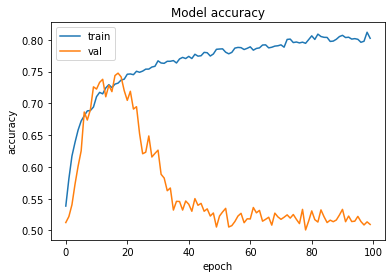

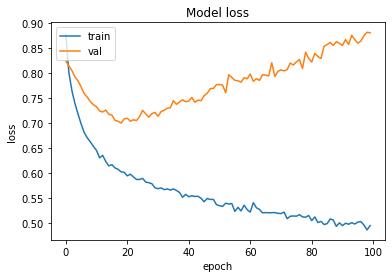

In [19]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model evaluation

In [20]:
test_generator = generator(path_test, y_test, eurosat_params['mean'], eurosat_params['std'], batch_size=BATCH_SIZE)
model_culture.evaluate_generator(test_generator,30)

[0.46674337685108186, 0.8041667]

In [42]:
Y_true = []
Y_pred = []
for i in range (0,30):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(model_culture.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)

In [43]:
cm = confusion_matrix(Y_true, Y_pred)

In [41]:
plot_confusion_matrix(cm)

TypeError: plot_confusion_matrix() missing 2 required positional arguments: 'X' and 'y_true'

In [45]:
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1055
           1       0.75      0.73      0.74       865

    accuracy                           0.77      1920
   macro avg       0.76      0.76      0.76      1920
weighted avg       0.77      0.77      0.77      1920

F1-Score : 0.7366568914956012


### Spatial - Cross Validation

In [12]:
culture_list = [1,2,6,15,18,19,17] #  6 caoutchou, 25 poivre de cayenne, 16 cassava, 23 intercrop
no_culture_list = [4,9,10, 24,27] # 11 other tree, 27 pines tree

In [13]:
data_train = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'spring_train_32.csv')))
data_train['geometry'] = data_train['geometry'].apply(wkt.loads)

data_train = data_train[data_train['label'].isin(culture_list + no_culture_list)]
data_train.loc[data_train['label'].isin(culture_list), 'label'] = 0
data_train.loc[data_train['label'].isin(no_culture_list), 'label'] =1

In [14]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.0001
DATA_AUGMENTATION_MULTIPLIATOR = 2
RUN_NAME = 'spacv_culture32_1'
NB_FOLD = 5

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME))

In [18]:
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall')
]

Training for fold 0
Epoch 1/100
70/70 [==============================] - 18s 154ms/step - loss: 0.9279 - accuracy: 0.6142 - precision: 0.5461 - recall: 0.6319 - val_loss: 0.9074 - val_accuracy: 0.5215 - val_precision: 0.9836 - val_recall: 0.4645
Epoch 2/100
70/70 [==============================] - 8s 122ms/step - loss: 0.7050 - accuracy: 0.8051 - precision: 0.7954 - recall: 0.7232 - val_loss: 0.9071 - val_accuracy: 0.5225 - val_precision: 0.9840 - val_recall: 0.4715
Epoch 3/100
70/70 [==============================] - 9s 123ms/step - loss: 0.5697 - accuracy: 0.8535 - precision: 0.8867 - recall: 0.7480 - val_loss: 0.9368 - val_accuracy: 0.5156 - val_precision: 0.9907 - val_recall: 0.4635
Epoch 4/100
70/70 [==============================] - 9s 124ms/step - loss: 0.5435 - accuracy: 0.8462 - precision: 0.8825 - recall: 0.7422 - val_loss: 0.8781 - val_accuracy: 0.5410 - val_precision: 0.9847 - val_recall: 0.4934
Epoch 5/100
70/70 [==============================] - 9s 123ms/step - loss: 0.47

50/50 [==============================] - 8s 166ms/step - loss: 0.2914 - accuracy: 0.9229 - precision: 0.9489 - recall: 0.9400 - val_loss: 1.0207 - val_accuracy: 0.5254 - val_precision: 0.3525 - val_recall: 0.9720
Epoch 20/100
50/50 [==============================] - 8s 166ms/step - loss: 0.3083 - accuracy: 0.9109 - precision: 0.9334 - recall: 0.9357 - val_loss: 0.9623 - val_accuracy: 0.5620 - val_precision: 0.3678 - val_recall: 0.9366
Epoch 21/100
50/50 [==============================] - 8s 166ms/step - loss: 0.2928 - accuracy: 0.9204 - precision: 0.9467 - recall: 0.9412 - val_loss: 0.9525 - val_accuracy: 0.5718 - val_precision: 0.3896 - val_recall: 0.9595
Epoch 22/100
50/50 [==============================] - 8s 165ms/step - loss: 0.2902 - accuracy: 0.9194 - precision: 0.9418 - recall: 0.9407 - val_loss: 0.9975 - val_accuracy: 0.5474 - val_precision: 0.3549 - val_recall: 0.9653
Epoch 23/100
50/50 [==============================] - 8s 166ms/step - loss: 0.3093 - accuracy: 0.9087 - preci

50/50 [==============================] - 8s 165ms/step - loss: 0.2110 - accuracy: 0.9474 - precision: 0.9591 - recall: 0.9647 - val_loss: 1.2126 - val_accuracy: 0.5654 - val_precision: 0.3659 - val_recall: 0.9486
Epoch 92/100
50/50 [==============================] - 8s 165ms/step - loss: 0.2038 - accuracy: 0.9429 - precision: 0.9628 - recall: 0.9520 - val_loss: 1.2807 - val_accuracy: 0.5396 - val_precision: 0.3655 - val_recall: 0.9620
Epoch 93/100
50/50 [==============================] - 8s 166ms/step - loss: 0.2174 - accuracy: 0.9360 - precision: 0.9499 - recall: 0.9582 - val_loss: 1.1675 - val_accuracy: 0.5557 - val_precision: 0.3683 - val_recall: 0.9538
Epoch 94/100
50/50 [==============================] - 8s 165ms/step - loss: 0.2207 - accuracy: 0.9447 - precision: 0.9557 - recall: 0.9614 - val_loss: 1.1342 - val_accuracy: 0.5742 - val_precision: 0.3729 - val_recall: 0.9695
Epoch 95/100
50/50 [==============================] - 8s 166ms/step - loss: 0.2247 - accuracy: 0.9357 - preci

82/82 [==============================] - 9s 106ms/step - loss: 0.3205 - accuracy: 0.8982 - precision: 0.9131 - recall: 0.8944 - val_loss: 0.5903 - val_accuracy: 0.7734 - val_precision: 0.2364 - val_recall: 0.4483
Epoch 63/100
82/82 [==============================] - 9s 106ms/step - loss: 0.3075 - accuracy: 0.9025 - precision: 0.9175 - recall: 0.8982 - val_loss: 0.5029 - val_accuracy: 0.8086 - val_precision: 0.4167 - val_recall: 0.4878
Epoch 64/100
82/82 [==============================] - 9s 106ms/step - loss: 0.2860 - accuracy: 0.9128 - precision: 0.9359 - recall: 0.9036 - val_loss: 0.5090 - val_accuracy: 0.8203 - val_precision: 0.2558 - val_recall: 0.4400
Epoch 65/100
82/82 [==============================] - 9s 106ms/step - loss: 0.2708 - accuracy: 0.9223 - precision: 0.9432 - recall: 0.9166 - val_loss: 0.5815 - val_accuracy: 0.7852 - val_precision: 0.3400 - val_recall: 0.4359
Epoch 66/100
82/82 [==============================] - 9s 106ms/step - loss: 0.3186 - accuracy: 0.9007 - preci

76/76 [==============================] - 8s 112ms/step - loss: 0.3108 - accuracy: 0.9034 - precision: 0.9166 - recall: 0.8960 - val_loss: 0.3543 - val_accuracy: 0.8809 - val_precision: 0.9366 - val_recall: 0.8000
Epoch 49/100
76/76 [==============================] - 8s 111ms/step - loss: 0.3312 - accuracy: 0.9000 - precision: 0.9116 - recall: 0.8885 - val_loss: 0.3868 - val_accuracy: 0.8809 - val_precision: 0.9330 - val_recall: 0.8058
Epoch 50/100
76/76 [==============================] - 8s 111ms/step - loss: 0.3081 - accuracy: 0.9041 - precision: 0.9102 - recall: 0.9017 - val_loss: 0.4816 - val_accuracy: 0.8496 - val_precision: 0.9461 - val_recall: 0.7452
Epoch 51/100
76/76 [==============================] - 8s 112ms/step - loss: 0.3206 - accuracy: 0.9049 - precision: 0.9122 - recall: 0.9024 - val_loss: 0.4423 - val_accuracy: 0.8555 - val_precision: 0.9391 - val_recall: 0.7490
Epoch 52/100
76/76 [==============================] - 8s 111ms/step - loss: 0.3097 - accuracy: 0.9086 - preci

54/54 [==============================] - 8s 142ms/step - loss: 0.3380 - accuracy: 0.9113 - precision: 0.9196 - recall: 0.8984 - val_loss: 0.3553 - val_accuracy: 0.8629 - val_precision: 0.9168 - val_recall: 0.8863
Epoch 30/100
54/54 [==============================] - 8s 142ms/step - loss: 0.3365 - accuracy: 0.9147 - precision: 0.9211 - recall: 0.9057 - val_loss: 0.3449 - val_accuracy: 0.8608 - val_precision: 0.9099 - val_recall: 0.8876
Epoch 31/100
54/54 [==============================] - 8s 143ms/step - loss: 0.3287 - accuracy: 0.9170 - precision: 0.9314 - recall: 0.8878 - val_loss: 0.3584 - val_accuracy: 0.8558 - val_precision: 0.9088 - val_recall: 0.8920
Epoch 32/100
54/54 [==============================] - 8s 141ms/step - loss: 0.3250 - accuracy: 0.9191 - precision: 0.9238 - recall: 0.9100 - val_loss: 0.3673 - val_accuracy: 0.8601 - val_precision: 0.9096 - val_recall: 0.8883
Epoch 33/100
54/54 [==============================] - 8s 142ms/step - loss: 0.3226 - accuracy: 0.9121 - preci

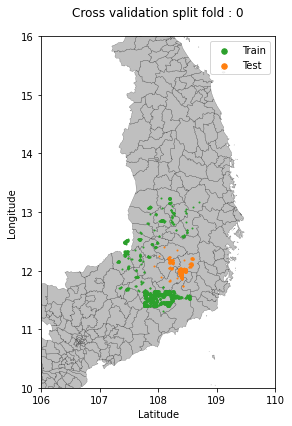

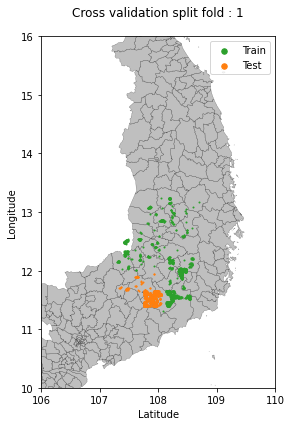

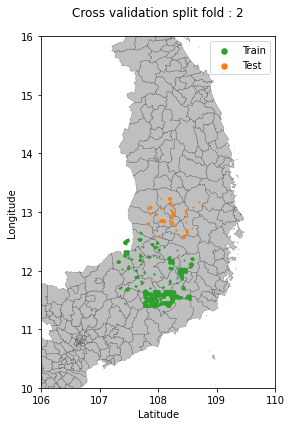

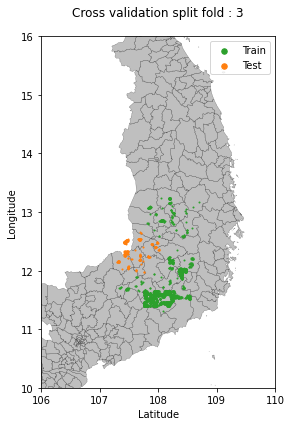

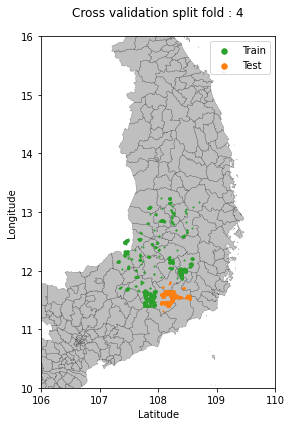

In [19]:
skcv = spacv.SKCV(n_splits=5, buffer_radius=0.1).split(data_train['geometry'])

fold_index = 0

results = []

for train, validation in skcv:
    geo_train = data_train.iloc[train]
    geo_val = data_train.iloc[validation]

    display_cross_val_map(geo_train, geo_val, map, f"Cross validation split fold : {fold_index}")

    print(f"Training for fold {fold_index}")

    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE, 
                                is_data_augmentation=True)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                                epochs=EPOCH,
                                steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                validation_data=validation_generator,
                                validation_steps=(len(geo_val)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                callbacks=[earlystopper])

    model.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    results.append(result)
    
    print(f"Fold {fold_index} loss : {result[0]}")
    print(f"Fold {fold_index} accuracy : {result[1]}")
    print("\n")

    K.clear_session()

    fold_index+=1

In [20]:
losses, accs, precisions, recalls = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")

Mean accuracy : 0.6953125
Stdev accuracy : 0.16692078608766794


Mean loss : 0.7048969566822052
Stdev loss : 0.35099698348291275


Mean precision : 0.6997291266918182
Stdev precision : 0.31808202895113946


Mean recall : 0.6868039131164551
Stdev recall : 0.2020345579847733


In [21]:
with open(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

In [30]:
data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'spring_test_32.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

data_test = data_test[data_test['label'].isin(culture_list + no_culture_list)]
data_test.loc[data_test['label'].isin(culture_list), 'label'] = 0
data_test.loc[data_test['label'].isin(no_culture_list), 'label'] =1

In [35]:
restored_model = load_model(os.path.join("saved_models/transfer_learning/Culture/spacv_culture32_1/spacv_culture32_1_3.h5"), custom_objects={'LeakyReLU':LeakyReLU})

1/1 [==============================] - 2s 2s/step - loss: 0.6015 - accuracy: 0.8497 - precision: 0.9375 - recall: 0.2830
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       412
           1       0.90      0.25      0.39       107

    accuracy                           0.84       519
   macro avg       0.87      0.62      0.65       519
weighted avg       0.85      0.84      0.80       519

F1-Score : 0.3941605839416058


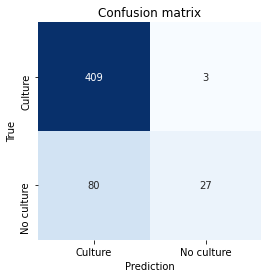

In [36]:
test_generator = generator(data_test['path'].to_numpy(), 
                            data_test['label'].to_numpy(), 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=519)
restored_model.evaluate(test_generator,steps=1)
Y_true = []
Y_pred = []
for i in range (0,1):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(restored_model.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)
cm = confusion_matrix(Y_true, Y_pred)
plot_confusion_matrix(cm, ["Culture", "No culture"])
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

### Stratified cross-val

In [10]:
data_train = gpd.GeoDataFrame(pd.read_csv(os.path.join( 'datasets', 'strat_spring_train_culture.csv')))
data_train['geometry'] = data_train['geometry'].apply(wkt.loads)

In [11]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.0001
DATA_AUGMENTATION_MULTIPLIATOR = 2
RUN_NAME = 'strat_culture_1'
NB_FOLD = 5

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME))
    
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall')
]

In [12]:
from sklearn.model_selection import StratifiedKFold

fold_index = 0

results = []

skf = StratifiedKFold(n_splits=5)
for train, validation in skf.split(data_train['path'].to_numpy(), data_train['label'].to_numpy()):
    
    geo_train = data_train.iloc[train]
    geo_val = data_train.iloc[validation]
    
    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE, 
                                is_data_augmentation=True)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                                epochs=EPOCH,
                                steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                validation_data=validation_generator,
                                validation_steps=(len(geo_val)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                callbacks=[earlystopper])

    model.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    result.append(2*((result[2]*result[3])/(result[2]+result[3])))
    results.append(result)
    
    print(f"Fold {fold_index} loss : {result[0]}")
    print(f"Fold {fold_index} accuracy : {result[1]}")
    print(f"Fold {fold_index} F1-score : {result[4]}")
    print("\n")

    K.clear_session()

    fold_index+=1

Epoch 1/100
36/36 [==============================] - 15s 207ms/step - loss: 0.9168 - accuracy: 0.6147 - precision: 0.5715 - recall: 0.7572 - val_loss: 0.6544 - val_accuracy: 0.8438 - val_precision: 0.9822 - val_recall: 0.6831
Epoch 2/100
36/36 [==============================] - 5s 140ms/step - loss: 0.6750 - accuracy: 0.8042 - precision: 0.8781 - recall: 0.6799 - val_loss: 0.5700 - val_accuracy: 0.8457 - val_precision: 0.9465 - val_recall: 0.7195
Epoch 3/100
36/36 [==============================] - 5s 139ms/step - loss: 0.5826 - accuracy: 0.8253 - precision: 0.8821 - recall: 0.7337 - val_loss: 0.5317 - val_accuracy: 0.8496 - val_precision: 0.9583 - val_recall: 0.6970
Epoch 4/100
36/36 [==============================] - 5s 137ms/step - loss: 0.5304 - accuracy: 0.8463 - precision: 0.9062 - recall: 0.7449 - val_loss: 0.4913 - val_accuracy: 0.8691 - val_precision: 0.9561 - val_recall: 0.7717
Epoch 5/100
36/36 [==============================] - 5s 140ms/step - loss: 0.4935 - accuracy: 0.862

36/36 [==============================] - 5s 145ms/step - loss: 0.4696 - accuracy: 0.8465 - precision: 0.8708 - recall: 0.7777 - val_loss: 0.3863 - val_accuracy: 0.8984 - val_precision: 0.9670 - val_recall: 0.8200
Epoch 10/100
36/36 [==============================] - 5s 143ms/step - loss: 0.4299 - accuracy: 0.8675 - precision: 0.9011 - recall: 0.8073 - val_loss: 0.4216 - val_accuracy: 0.8945 - val_precision: 0.9548 - val_recall: 0.7860
Epoch 11/100
36/36 [==============================] - 5s 146ms/step - loss: 0.3934 - accuracy: 0.8938 - precision: 0.9317 - recall: 0.8421 - val_loss: 0.3964 - val_accuracy: 0.8926 - val_precision: 0.9431 - val_recall: 0.8223
Epoch 12/100
36/36 [==============================] - 5s 142ms/step - loss: 0.4338 - accuracy: 0.8701 - precision: 0.8883 - recall: 0.8266 - val_loss: 0.4186 - val_accuracy: 0.8691 - val_precision: 0.9190 - val_recall: 0.7942
Epoch 13/100
36/36 [==============================] - 5s 143ms/step - loss: 0.4366 - accuracy: 0.8766 - preci

36/36 [==============================] - 5s 141ms/step - loss: 0.2772 - accuracy: 0.9272 - precision: 0.9426 - recall: 0.8938 - val_loss: 0.2687 - val_accuracy: 0.9297 - val_precision: 0.9649 - val_recall: 0.8871
Epoch 82/100
36/36 [==============================] - 5s 142ms/step - loss: 0.2630 - accuracy: 0.9224 - precision: 0.9299 - recall: 0.9022 - val_loss: 0.2906 - val_accuracy: 0.9199 - val_precision: 0.9415 - val_recall: 0.8694
Epoch 83/100
36/36 [==============================] - 5s 140ms/step - loss: 0.2618 - accuracy: 0.9316 - precision: 0.9520 - recall: 0.9079 - val_loss: 0.3157 - val_accuracy: 0.9043 - val_precision: 0.9283 - val_recall: 0.8625
Epoch 84/100
36/36 [==============================] - 5s 139ms/step - loss: 0.2722 - accuracy: 0.9262 - precision: 0.9384 - recall: 0.9003 - val_loss: 0.2677 - val_accuracy: 0.9277 - val_precision: 0.9469 - val_recall: 0.9062
Epoch 85/100
36/36 [==============================] - 5s 141ms/step - loss: 0.2490 - accuracy: 0.9340 - preci

36/36 [==============================] - 5s 139ms/step - loss: 0.2902 - accuracy: 0.9174 - precision: 0.9157 - recall: 0.9158 - val_loss: 0.2822 - val_accuracy: 0.9277 - val_precision: 0.9358 - val_recall: 0.8987
Epoch 53/100
36/36 [==============================] - 5s 139ms/step - loss: 0.2853 - accuracy: 0.9309 - precision: 0.9493 - recall: 0.9072 - val_loss: 0.2892 - val_accuracy: 0.9336 - val_precision: 0.9824 - val_recall: 0.8814
Epoch 54/100
36/36 [==============================] - 5s 139ms/step - loss: 0.2851 - accuracy: 0.9288 - precision: 0.9475 - recall: 0.9018 - val_loss: 0.2688 - val_accuracy: 0.9277 - val_precision: 0.9309 - val_recall: 0.9197
Epoch 55/100
36/36 [==============================] - 5s 140ms/step - loss: 0.3079 - accuracy: 0.9168 - precision: 0.9252 - recall: 0.8992 - val_loss: 0.2868 - val_accuracy: 0.9297 - val_precision: 0.9532 - val_recall: 0.8996
Epoch 56/100
36/36 [==============================] - 5s 140ms/step - loss: 0.2937 - accuracy: 0.9213 - preci

36/36 [==============================] - 5s 138ms/step - loss: 0.3123 - accuracy: 0.9228 - precision: 0.9366 - recall: 0.8917 - val_loss: 0.2884 - val_accuracy: 0.9238 - val_precision: 0.8920 - val_recall: 0.9489
Epoch 40/100
36/36 [==============================] - 5s 139ms/step - loss: 0.3126 - accuracy: 0.9136 - precision: 0.9186 - recall: 0.8893 - val_loss: 0.2844 - val_accuracy: 0.9238 - val_precision: 0.9053 - val_recall: 0.9322
Epoch 41/100
36/36 [==============================] - 5s 138ms/step - loss: 0.3312 - accuracy: 0.9072 - precision: 0.9126 - recall: 0.8715 - val_loss: 0.2957 - val_accuracy: 0.9043 - val_precision: 0.8806 - val_recall: 0.9328
Epoch 42/100
36/36 [==============================] - 5s 138ms/step - loss: 0.3357 - accuracy: 0.9020 - precision: 0.9160 - recall: 0.8737 - val_loss: 0.2965 - val_accuracy: 0.9121 - val_precision: 0.8953 - val_recall: 0.9277
Epoch 43/100
36/36 [==============================] - 5s 140ms/step - loss: 0.2912 - accuracy: 0.9337 - preci

36/36 [==============================] - 5s 139ms/step - loss: 0.3460 - accuracy: 0.9218 - precision: 0.9294 - recall: 0.9004 - val_loss: 0.3943 - val_accuracy: 0.8789 - val_precision: 0.8565 - val_recall: 0.8788
Epoch 20/100
36/36 [==============================] - 5s 139ms/step - loss: 0.3682 - accuracy: 0.9040 - precision: 0.9216 - recall: 0.8721 - val_loss: 0.3818 - val_accuracy: 0.8945 - val_precision: 0.9087 - val_recall: 0.8438
Epoch 21/100
36/36 [==============================] - 5s 136ms/step - loss: 0.3671 - accuracy: 0.9006 - precision: 0.9316 - recall: 0.8526 - val_loss: 0.4088 - val_accuracy: 0.8633 - val_precision: 0.8805 - val_recall: 0.8223
Epoch 22/100
36/36 [==============================] - 5s 138ms/step - loss: 0.3573 - accuracy: 0.8968 - precision: 0.9062 - recall: 0.8724 - val_loss: 0.3579 - val_accuracy: 0.9043 - val_precision: 0.9321 - val_recall: 0.8583
Epoch 23/100
36/36 [==============================] - 5s 140ms/step - loss: 0.3321 - accuracy: 0.9195 - preci

36/36 [==============================] - 5s 137ms/step - loss: 0.2469 - accuracy: 0.9387 - precision: 0.9700 - recall: 0.8974 - val_loss: 0.2920 - val_accuracy: 0.9277 - val_precision: 0.9378 - val_recall: 0.9113
Epoch 92/100
36/36 [==============================] - 5s 137ms/step - loss: 0.2522 - accuracy: 0.9351 - precision: 0.9540 - recall: 0.9085 - val_loss: 0.2703 - val_accuracy: 0.9414 - val_precision: 0.9651 - val_recall: 0.9095
Epoch 93/100
36/36 [==============================] - 5s 137ms/step - loss: 0.2580 - accuracy: 0.9243 - precision: 0.9408 - recall: 0.8981 - val_loss: 0.2701 - val_accuracy: 0.9277 - val_precision: 0.9414 - val_recall: 0.9073
Epoch 94/100
36/36 [==============================] - 5s 137ms/step - loss: 0.2492 - accuracy: 0.9342 - precision: 0.9467 - recall: 0.9144 - val_loss: 0.3196 - val_accuracy: 0.9180 - val_precision: 0.9518 - val_recall: 0.8750
Epoch 95/100
36/36 [==============================] - 5s 135ms/step - loss: 0.2556 - accuracy: 0.9324 - preci

In [13]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.9265625
Stdev accuracy : 0.016646309181767592


Mean loss : 0.27794947624206545
Stdev loss : 0.027769519540595488


Mean precision : 0.9395267963409424
Stdev precision : 0.023373058774516606


Mean recall : 0.8953775048255921
Stdev recall : 0.03805134136252921


Mean F1-Score : 0.9162076730067013
Stdev F1-Score : 0.018911896167159256


In [14]:
with open(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

In [15]:
data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join( 'datasets', 'strat_spring_test_culture.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

In [16]:
restored_model = load_model(os.path.join("saved_models/transfer_learning/Culture/strat_culture_1/strat_culture_1_1.h5"), custom_objects={'LeakyReLU':LeakyReLU})

1/1 [==============================] - 5s 5s/step - loss: 0.2659 - accuracy: 0.9307 - precision: 0.9747 - recall: 0.8750
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       199
           1       0.97      0.88      0.92       176

    accuracy                           0.93       375
   macro avg       0.94      0.93      0.93       375
weighted avg       0.93      0.93      0.93       375

F1-Score : 0.9221556886227545


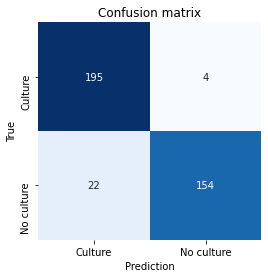

In [17]:
test_generator = generator(data_test['path'].to_numpy(), 
                            data_test['label'].to_numpy(), 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=len(data_test))
restored_model.evaluate(test_generator,steps=1)
Y_true = []
Y_pred = []
for i in range (0,1):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(restored_model.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)
cm = confusion_matrix(Y_true, Y_pred)
plot_confusion_matrix(cm, ["Culture", "No culture"])
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

## Model evaluation

In [54]:
restored_model = get_best_cross_val_model(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME), RUN_NAME, results, custom_objects={'LeakyReLU':LeakyReLU})

In [24]:
test_generator = generator(path_test, 
                            y_test, 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=BATCH_SIZE)
restored_model.evaluate(test_generator,steps=30)

30/30 [==============================] - 6s 130ms/step - loss: 0.2563 - accuracy: 0.9328


[0.25634971261024475, 0.932812511920929]

In [25]:
Y_true = []
Y_pred = []
for i in range (0,30):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(model_culture.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)

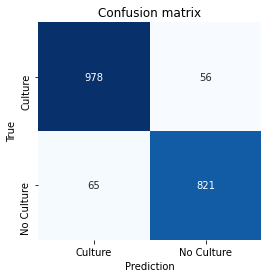

In [27]:
cm = confusion_matrix(Y_true, Y_pred)
plot_confusion_matrix(cm, ["Culture", "No Culture"])

In [28]:
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1034
           1       0.94      0.93      0.93       886

    accuracy                           0.94      1920
   macro avg       0.94      0.94      0.94      1920
weighted avg       0.94      0.94      0.94      1920

F1-Score : 0.9313669880884855


In [29]:
pd.DataFrame({"path_train":path_train, "y_train":y_train}).to_csv("datasets/spring_train.csv", index=False)

In [30]:
pd.DataFrame({"path_test":path_test, "y_test":y_test}).to_csv("datasets/spring_test.csv", index=False)